In [712]:
import sys, os
import matplotlib.pyplot as plt
import requests
import json
import pandas as pd
from pandas.io import sql
from pandas.io.json import json_normalize
import numpy as np
from sqlalchemy import types, create_engine
from datetime import date, timedelta
from datetime import datetime
import time
import re
import pylab as py
from matplotlib import gridspec
import matplotlib.dates as md
from sklearn.model_selection import LeaveOneOut
os.environ['PROJ_LIB'] = '/home/ehsan/anaconda3/share/proj'
import matplotlib
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon

In [608]:
df = pd.read_csv("Tmax_Data_Not_Filled.txt", encoding = "ISO-8859-1", engine='python')

In [609]:
meta_columns = ['SKN', 'Station.Name', 'Sta..ID', 'Island', 'Network', 'LON', 'LAT', 'Elev.']
Temp_columns = df.columns[8:]
Temp_columns

Index(['X1990.01.01', 'X1990.01.02', 'X1990.01.03', 'X1990.01.04',
       'X1990.01.05', 'X1990.01.06', 'X1990.01.07', 'X1990.01.08',
       'X1990.01.09', 'X1990.01.10',
       ...
       'X2014.12.22', 'X2014.12.23', 'X2014.12.24', 'X2014.12.25',
       'X2014.12.26', 'X2014.12.27', 'X2014.12.28', 'X2014.12.29',
       'X2014.12.30', 'X2014.12.31'],
      dtype='object', length=9131)

In [763]:
df2 = df[meta_columns]
df2 = df2.set_index("SKN")

print(len(df2))

df2.head()

142


,Station.Name,Sta..ID,Island,Network,LON,LAT,Elev.
SKN,,,,,,,
337.2,Puu o Pele,CN1,Ma,CraterNet,-156.212261,20.718443,2281.0
337.3,Lava lake,CN2,Ma,CraterNet,-156.188007,20.717807,2258.0
337.6,Puu Nole,CN3,Ma,CraterNet,-156.224485,20.709651,2430.0
337.4,Silversword loop,CN4,Ma,CraterNet,-156.205387,20.731704,2185.0
337.0,south rim,CN5,Ma,CraterNet,-156.239400,20.714563,2704.0


In [764]:
df2.groupby("Island").count()

,Station.Name,Sta..ID,Network,LON,LAT,Elev.
Island,,,,,,
BI,32,32,32,32,32,32
Bi,19,19,19,19,19,19
Ka,14,14,14,14,14,14
Ko,5,5,5,5,5,5
La,2,2,2,2,2,2
Ma,31,31,31,31,31,31
Mo,6,6,6,6,6,6
Oa,33,33,33,33,33,33


In [765]:
df2 = df2[df2.Island=='Oa']
print(len(df2))

df2.head()

33


,Station.Name,Sta..ID,Island,Network,LON,LAT,Elev.
SKN,,,,,,,
903.10,B Y U LAIE 903.1,510242,Oa,COOP,-157.929,21.645,2.0
841.16,CAMP ERDMAN 841.16,510305,Oa,COOP,-158.224,21.579,3.0
702.20,HONOLULU OBSERV 702.2,511918,Oa,COOP,-158.000,21.314,2.0
781.00,KANEOHE MAUKA 781,513113,Oa,COOP,-157.811,21.408,61.0
838.10,KANEOHE 838.1,513117,Oa,COOP,-157.804,21.423,18.0


In [795]:
df1 = df[["SKN"]+list(Temp_columns)].T

new_header = df1.iloc[0]
df1 = df1[1:] 
df1.columns = new_header 

df1.index = pd.to_datetime([x.split('X')[1] for x in df1.index.values])
df1.index.name = 'Date'

df1 = df1[list(df2.index.values)]

df1 = df1.resample('1W').mean()

print(len(df1))
df1.tail(5)

1305


SKN,903.10,841.16,702.20,781.00,838.10,904.10,886.90,870.00,855.30,725.60,...,842.70,842.80,842.90,885.70,828.00,858.00,857.40,799.00,752.60,803.20
Date,,,,,,,,,,,,,,,,,,,,,
2014-12-07,NaN,NaN,26.675000,NaN,24.914286,NaN,24.266667,27.220000,23.814286,NaN,...,24.815000,26.428429,NaN,18.055333,23.492143,23.888833,22.381,NaN,26.904714,26.269714
2014-12-14,NaN,NaN,27.680000,NaN,27.142857,NaN,26.300000,26.800000,25.628571,NaN,...,26.111286,27.063571,27.222,20.317286,24.841429,24.682571,25.556,NaN,28.174571,28.174857
2014-12-21,NaN,NaN,28.300000,NaN,25.328571,NaN,NaN,26.220000,24.757143,NaN,...,26.587286,27.936429,NaN,19.126857,23.730143,24.126857,NaN,NaN,28.650714,28.333429
2014-12-28,NaN,NaN,26.833333,NaN,25.557143,NaN,NaN,25.850000,23.500000,NaN,...,24.047429,24.841286,NaN,19.047714,22.460143,22.301571,NaN,NaN,26.190429,25.079286
2015-01-04,NaN,NaN,26.100000,NaN,25.200000,NaN,NaN,27.233333,23.300000,NaN,...,23.333333,24.630000,NaN,19.444333,22.592667,21.666333,NaN,NaN,25.740667,24.074000


In [796]:
df3 = df2[["LON", "LAT", "Elev."]].T
df3 = df3[list(df2.index.values)]
df3

SKN,903.10,841.16,702.20,781.00,838.10,904.10,886.90,870.00,855.30,725.60,...,842.70,842.80,842.90,885.70,828.00,858.00,857.40,799.00,752.60,803.20
LON,-157.929,-158.224,-158.000,-157.811,-157.804,-157.91,-157.837,-158.0378,-158.089,-158.094,...,-158.204,-158.226,-158.199,-157.900,-157.993,-158.082,-158.115,-158.107,-157.981,-158.179
LAT,21.645,21.579,21.314,21.408,21.423,21.61,21.521,21.5739,21.538,21.395,...,21.526,21.529,21.543,21.499,21.499,21.495,21.509,21.480,21.387,21.452
Elev.,2.000,3.000,2.000,61.000,18.000,0.90,7.000,288.0000,220.000,510.000,...,158.000,6.000,533.000,699.000,381.000,299.000,347.000,454.000,2.000,292.000


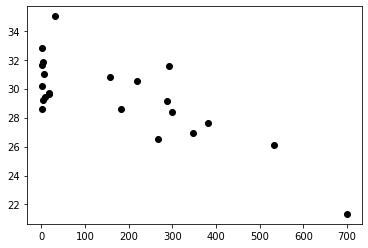

In [797]:
plt.plot(df3.iloc[2].values, df1.loc["2014-08-31"].values, 'ko')

<ipython-input-798-5fa134680507>:4: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  map = Basemap(llcrnrlon=-160.5,llcrnrlat=18.5,urcrnrlon=-154.5,urcrnrlat=22.5, projection='cyl')
<ipython-input-798-5fa134680507>:6: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  shp_info = map.readshapefile('st99_d00','states',drawbounds=True,
<ipython-input-798-5fa134680507>:8: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  shp_info_ = map.readshapefile('st99_d00','states',drawbounds=False)


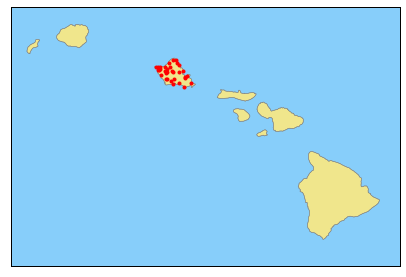

In [798]:
fig=plt.figure(figsize=(6,4))
ax = fig.add_axes([0.05,0.05,0.9,0.9])

map = Basemap(llcrnrlon=-160.5,llcrnrlat=18.5,urcrnrlon=-154.5,urcrnrlat=22.5, projection='cyl')

shp_info = map.readshapefile('st99_d00','states',drawbounds=True,
                           linewidth=0.45,color='gray')
shp_info_ = map.readshapefile('st99_d00','states',drawbounds=False)


map.drawmapboundary(fill_color='lightskyblue')

for lon, lat in list(zip(df2.LON.values, df2.LAT.values)):
    
    x, y = map(lon, lat)
    map.plot(x, y, marker='o',color='red',markersize=3)

for nshape, shapedict in enumerate(map.states_info):
     if shapedict['NAME'] in ['Hawaii']:
         seg = map.states[int(shapedict['SHAPENUM'] - 1)]
         poly = Polygon(seg, facecolor='khaki', edgecolor='gray', linewidth=.45)
         ax.add_patch(poly)

# ax.annotate("Oahu",(-158.27,21.8), fontsize=12)
# ax.annotate("Maui",(-156.28,20.98), fontsize=12)
# ax.annotate("Hawaii",(-155.8,19.54), fontsize=12)
# ax.annotate("Molokai",(-157.23,21.31), fontsize=12)
# ax.annotate("Kauai",(-159.7,21.7), fontsize=12)
# ax.annotate("Lanai",(-157.55,20.74), fontsize=12)

# ax.annotate("HAWAII",(-160.24,18.75), fontsize=16)

In [799]:
df_station =  df3.T
df_station = df_station.join(df1.T, how='left')

df_station.tail()

,LON,LAT,Elev.,1990-01-07 00:00:00,1990-01-14 00:00:00,1990-01-21 00:00:00,1990-01-28 00:00:00,1990-02-04 00:00:00,1990-02-11 00:00:00,1990-02-18 00:00:00,...,2014-11-02 00:00:00,2014-11-09 00:00:00,2014-11-16 00:00:00,2014-11-23 00:00:00,2014-11-30 00:00:00,2014-12-07 00:00:00,2014-12-14 00:00:00,2014-12-21 00:00:00,2014-12-28 00:00:00,2015-01-04 00:00:00
SKN,,,,,,,,,,,,,,,,,,,,,
858.0,-158.082,21.495,299.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,25.635000,26.018500,25.793714,25.793571,23.015857,23.888833,24.682571,24.126857,22.301571,21.666333
857.4,-158.115,21.509,347.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24.047429,25.317429,25.079429,24.761857,21.587429,22.381000,25.556000,NaN,NaN,NaN
799.0,-158.107,21.480,454.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
752.6,-157.981,21.387,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,29.682571,30.000143,29.444286,29.603143,26.587143,26.904714,28.174571,28.650714,26.190429,25.740667
803.2,-158.179,21.452,292.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,28.254000,29.523714,29.047571,29.285571,25.317571,26.269714,28.174857,28.333429,25.079286,24.074000


In [800]:
Date = pd.to_datetime("2014-12-07")

data = df_station[["LON", "LAT", "Elev.", Date]].dropna()

data.head()

,LON,LAT,Elev.,2014-12-07 00:00:00
SKN,,,,
702.2,-158.0000,21.3140,2.0,26.675000
838.1,-157.8040,21.4230,18.0,24.914286
886.9,-157.8370,21.5210,7.0,24.266667
870.0,-158.0378,21.5739,288.0,27.220000
855.3,-158.0890,21.5380,220.0,23.814286


In [801]:
X = data[["LON", "LAT", "Elev."]].values

y = data[Date].values

In [802]:
from scipy.optimize import minimize
import george
from george import kernels
from sklearn.model_selection import KFold

In [803]:
def nll_fn2(X, y):
    
    

    def step(theta):
        
#         kf = KFold(n_splits=3)
        loo = LeaveOneOut()
        XI2 = 0
        
#         for train_index, test_index in kf.split(X):
        for train_index, test_index in loo.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
        
        
            N = X_train.shape[0]
            zp = theta[0]
            slope = theta[1]
            l = np.exp(theta[2])
            sigma = np.exp(theta[3])
            s2 = theta[4]

            y_model = slope*X_train[:,2]+zp
            ind, = np.where(X_train[:,2]>2150)
            y_model[ind] += s2*(X_train[:,2][ind]-2150)

            kernel = sigma * kernels.ExpSquaredKernel([l,l], ndim=2)
            gp = george.GP(kernel)
            gp.compute(X_train[:,:2], np.exp(theta[5]))

            y_res_test, _ = gp.predict(y_train-y_model, X_test[:,:2], return_var=True)
            
            
            y_model_test = slope*X_test[:,2]+zp
            ind, = np.where(X_test[:,2]>2150)
            y_model_test[ind] += s2*(X_test[:,2][ind]-2150)           
            
            XI2 += np.sum((y_res_test+y_model_test - y_test)**2)
            
        return XI2
    
    
    return step


# Maximum Likelihood
pos = minimize(nll_fn2(X, y), [0, -0.0001, 1, 0, 0.005,1], method='SLSQP', 
              bounds=((0,60), (-0.01, -0.0001), 
                      (None, 3), (None,10), 
                      (-0.0001,0.01), (1,1)))
print(pos)

     fun: 46.925118428360875
     jac: array([ 8.07857513e-03,  3.64056587e-01,  4.92572784e-04, -2.33650208e-05,
        0.00000000e+00,  2.38418579e-06])
 message: 'Optimization terminated successfully.'
    nfev: 189
     nit: 23
    njev: 23
  status: 0
 success: True
       x: array([ 5.62622026e-16, -9.50439394e-03,  7.48357503e-01,  5.37749747e+00,
        5.00000000e-03,  1.00000000e+00])


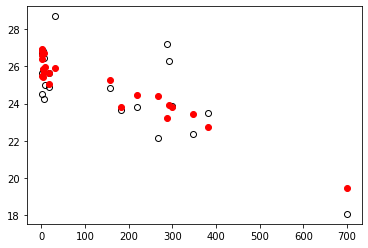

In [804]:
plt.plot(df3.iloc[2].values, df1.loc[Date].values, 'ko', mfc='none')

theta = pos.x
loo = LeaveOneOut()

u = []
v = []

for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


    N = X_train.shape[0]
    zp = theta[0]
    slope = theta[1]
    l = np.exp(theta[2])
    sigma = np.exp(theta[3])
    s2 = theta[4]

    y_model = slope*X_train[:,2]+zp
    ind, = np.where(X_train[:,2]>2150)
    y_model[ind] += s2*(X_train[:,2][ind]-2150)

    kernel = sigma * kernels.ExpSquaredKernel([l,l], ndim=2)
    gp = george.GP(kernel)
    gp.compute(X_train[:,:2], np.exp(theta[5]))

    y_res_test, _ = gp.predict(y_train-y_model, X_test[:,:2], return_var=True)


    y_model_test = slope*X_test[:,2]+zp
    ind, = np.where(X_test[:,2]>2150)
    y_model_test[ind] += s2*(X_test[:,2][ind]-2150)    
    
    
    plt.plot(X_test[:,2], y_res_test+y_model_test , 'ro')
    
    u.append(y_res_test[0])
    v.append(y_test[0]-y_model_test[0])
    


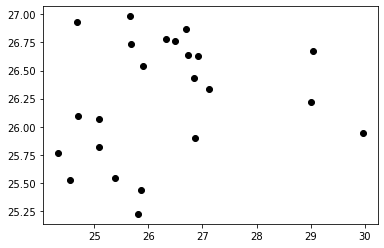

In [805]:
plt.plot(v, u, 'ko')

In [294]:
# # Import modules
# import numpy as np
# from pyswarms.single.global_best import GlobalBestPSO
# # Import PySwarms
# import pyswarms as ps
# from pyswarms.utils.functions import single_obj as fx

# # Some more magic so that the notebook will reload external python modules;
# # see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
# %load_ext autoreload
# %autoreload 2

In [295]:
# def lnlike(theta):
    
#     N = X.shape[0]

#     zp = 25.+theta[0]
#     slope = theta[1]
#     l = np.exp(theta[2])
#     sigma = np.exp(theta[3])

#     yerr = y - (slope*X[:,2]+zp)

#     kernel = sigma * kernels.ExpSquaredKernel([l,l], ndim=2, axes=[0, 1])
#     gp = george.GP(kernel)
#     gp.compute(X[:,:2], yerr)

#     #sys.exit()
#     # Compute determinant via Cholesky decomposition
#     return gp.lnlikelihood(yerr)
    
    
    
# def Xi2_swarm(x):
  
#     nParticle = x.shape[0]
#     out = np.zeros(nParticle)

#     for n_iter in range(nParticle):
        
#         theta = x[n_iter,:]        
#         out[n_iter] = -np.exp(lnlike(theta))  # to be minimzed

#     return out 

In [296]:
# %%time
# # Set-up hyperparameters
# options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

# # Call instance of PSO
# optimizer = GlobalBestPSO(n_particles=1000, dimensions=4, options=options)

# # Perform optimization
# cost, pos = optimizer.optimize(Xi2_swarm, iters=1000)

# print(pos)